In [216]:
#import relevant libraries
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [278]:
#load the defect data
dfta = pd.read_excel(r'Fault.xls', parse_dates = ['Record Date'])

# 1 Data Cleaning 

In [279]:
#replace columns name empty space with '_'

dfta.columns = dfta.columns.str.replace(" ","_")

In [280]:
#check for data info. 2 null data on column 1.
print(dfta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35342 entries, 0 to 35341
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Record_Date             35342 non-null  datetime64[ns]
 1   Activity_Type           35340 non-null  object        
 2   Service_Number          35342 non-null  object        
 3   Service_Fault_Symptoms  35342 non-null  object        
 4   Fault_Group             35342 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.3+ MB
None


In [281]:
#check rows for null. Since there is no Service Fault Symptoms, this is a non-service fault.
dfta[dfta['Activity_Type'].isnull()]

,Record_Date,Activity_Type,Service_Number,Service_Fault_Symptoms,Fault_Group
23019,2017-07-20,NaN,Nil,-,Nil
23278,2017-08-19,NaN,Nil,-,Nil


In [282]:
#replace the Null with "nil"
dfta.loc[:,'Activity_Type'].fillna('nil', inplace=True)

In [283]:
#check for maintenance activity types 
print(dfta['Activity_Type'].unique())
print('\n')

#keep only corrective maintenance defects (Activity type 3)
dfta3 = dfta[dfta['Activity_Type'] == '003']
print(dfta3.shape) #fitlered ~4000 rows of data

['003' '008' '002' 'CIH' 'CAT' 'WSH' '001' '006' '007' 'nil' '004' '009']


(31949, 5)


In [284]:
#check for maintenance service number unique counts.
dfta3.Service_Number.value_counts()

Nil            16474
OBTSC396487        3
RICTC156751        3
OBTSC296323        2
OBTSC302917        2
               ...  
OBTSC428717        1
OBTSC428582        1
OBTSC430789        1
OBTSC430266        1
RICTC185708        1
Name: Service_Number, Length: 15289, dtype: int64

In [285]:
#(Alternate)check for maintenance service number unique counts using .contains
print(dfta3.Service_Number.str.contains("Nil").value_counts())
print('\n')

#remove all the non-service defects
dfta3 = dfta3[~dfta3.Service_Number.str.contains("Nil")]
print(dfta3.shape)

True     16474
False    15475
Name: Service_Number, dtype: int64


(15475, 5)


In [286]:
#check how many service defect has no symptoms reported
print(dfta3.Service_Fault_Symptoms.str.contains(r"-$").value_counts())
print('\n')

#remove all the service defect has no symptoms reported
dfta3 = dfta3[~dfta3.Service_Fault_Symptoms.str.contains(r"-$")]
print(dfta3.shape)

False    11858
True      3617
Name: Service_Fault_Symptoms, dtype: int64


(11858, 5)


# 2 Exploratory Data Analysis

['Fire Detection System' 'Air Condition System' 'Interior Equipment'
 'Control System' 'Miscellaneous' 'Lighting System' 'Propulsion System'
 'PAPIS Equipment' 'Brake System' 'Battery System' 'Audio'
 'Saloon Door System' 'Pneumatic Supply System' 'Auxiliary System'
 'Carbody Equipment' 'Bogie Equipment' 'Electrical System' 'Gangway'
 'Interior System' 'Coupler System' 'Miscellaneous System' 'Nil'
 'Saloon Air Conditioning System' 'Lighting Equipment'
 'ALS Auxiliary Power Supply Sys' 'Emergency Door System'
 'ALS Propulsion System' 'Pneumatic System' 'Axle/Wheel Set'
 "Driver's Console" 'Auxiliary Control Electronics'
 'Communication Power Supply' 'Air Conditioning System']




<AxesSubplot:xlabel='Fault_Group', ylabel='index'>

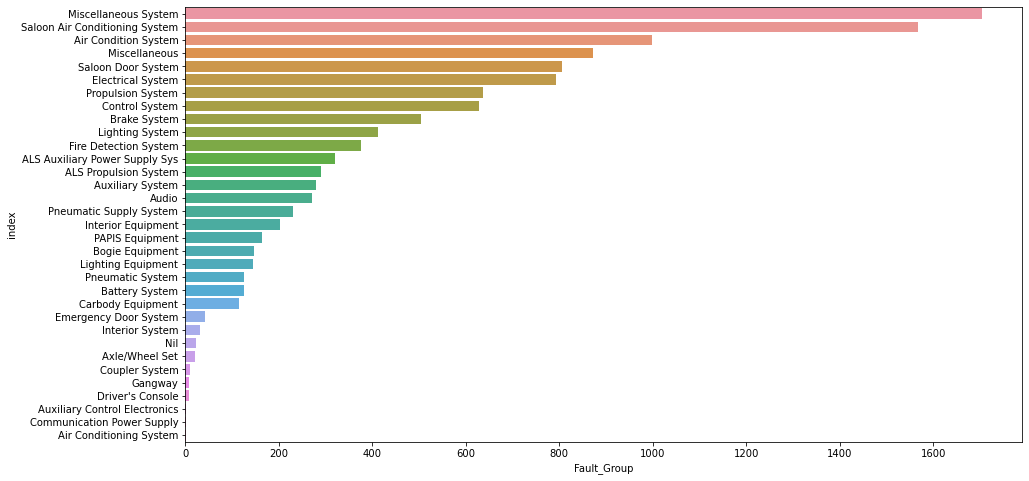

In [288]:
"""
looking at the number of fault groups,
there are duplicates within fault groups (e.g miscellaneous and miscellaneous system). 
However, majority is dominated by Misc and Aircon faults.
there are also Nil. Since the count is low,to remove it.
"""

print(dfta3.Fault_Group.unique())

print("\n")

FG = dfta3.Fault_Group.value_counts()
FG = pd.DataFrame(data = FG)
plt.figure(figsize = (15,8))
FG.reset_index(inplace=True)
sns.barplot(x="Fault_Group",y = "index", data=FG)

In [289]:
#check for the trend of miscellaneous system
misc = dfta3.loc[(dfta3.Fault_Group == "Miscellaneous System")|(dfta3.Fault_Group == "Miscellaneous")]

<AxesSubplot:xlabel='Record_Date', ylabel='Count'>

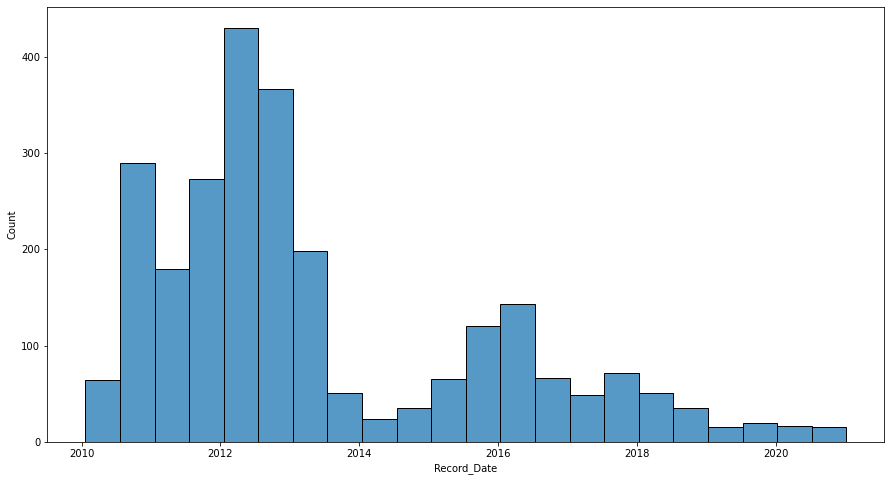

In [290]:
"""
Majority of the data classified as miscellaneous happened in the earlier years
where categorisation of fault is still under standardisation. This can cause noise to the ML model.
To remove misc category fault group.
"""

plt.figure(figsize = (15,8))
sns.histplot(x="Record_Date", data=misc)

In [291]:
#remove all the service Fault_Group categorised as miscellaneous and Nil. This removed ~25% data.
dfta3 = dfta3[~dfta3.Fault_Group.str.contains("Miscellaneous System|Nil|Miscellaneous")]
print(dfta3.shape)

(9258, 5)


In [292]:
#differentiate safety and non safety related defect with the remaining fault group. 

dfta3.loc[~(dfta3["Fault_Group"].str.contains("Saloon Air Conditioning System|Air Condition System|Lighting System|Interior Equipment|Interior System|Audio|Lighting Equipment|PAPIS Equipment|Carbody Equipment|Air Conditioning System|Communication Power Supply", regex = True)), "Defect_Type" ] = 'Safety Impact Defects'
dfta3.loc[(dfta3["Fault_Group"].str.contains("Saloon Air Conditioning System|Air Condition System|Lighting System|Interior Equipment|Interior System|Audio|Lighting Equipment|PAPIS Equipment|Carbody Equipment|Air Conditioning System|Communication Power Supply")), "Defect_Type"] = 'Non Safety Impact Defects'                   

In [293]:
#safety and non safety defect count
dfta3gb = dfta3.groupby(by = "Defect_Type")
dfta3gb.Defect_Type.value_counts()

Defect_Type                Defect_Type              
Non Safety Impact Defects  Non Safety Impact Defects    3905
Safety Impact Defects      Safety Impact Defects        5353
Name: Defect_Type, dtype: int64

In [294]:
dfta3.sample(2)

,Record_Date,Activity_Type,Service_Number,Service_Fault_Symptoms,Fault_Group,Defect_Type
35291,2020-12-28,003,RICTC185647,XX27. ATS alarm and TIP indicated Remote Input...,Control System,Safety Impact Defects
29575,2019-06-22,003,RICTC144073,XX17. ATS alarm and TIP indicated car7 auxilia...,Auxiliary System,Safety Impact Defects


# 3 Machine Learning

## Data Preparation

In [295]:
#extract the required features for ML
features = dfta3.loc[:,["Service_Fault_Symptoms","Defect_Type"]]

In [296]:
#convert Fault Group to a numerical variable
features['Defect_Type'] = features['Defect_Type'].map({'Safety Impact Defects':1, 'Non Safety Impact Defects':0}).copy()
features.head()

,Service_Fault_Symptoms,Defect_Type
8,ATS alarm manager and TIP showed car 5 smoke f...,1
16,ATS alarm manager and TIP showed car 5 smoke f...,1
22,SNAPREP XX38: pax reported 8385 fan not workin...,0
36,XX51 Pax feedback of no aircon. Car 1 & 7 hav...,0
57,"XX17, driver reported Car1 fire extinguisher p...",0


In [297]:
#2 Define X and y (from the FDS data) for use with COUNTVECTORIZER
X = features.Service_Fault_Symptoms
y = features.Defect_Type
print(X.shape)
print(y.shape)

(9258,)
(9258,)


In [298]:
"""
#3 split X and y into training and testing sets
 by default, it splits 75% training and 25% test
 random_state=1 for reproducibility
"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6943,)
(2315,)
(6943,)
(2315,)


In [299]:
#4 import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer

#5 instantiate the vectorizer
vect = CountVectorizer()

In [300]:
#5 combine fit and transform 
X_train_ft = vect.fit_transform(X_train)
X_train_ft

<6943x5067 sparse matrix of type '<class 'numpy.int64'>'
	with 149941 stored elements in Compressed Sparse Row format>

In [301]:
#6 transform testing data, using fitted vocabulary from X_train, into a document-term matrix.

#5067 unique words in x_train
X_test_ft = vect.transform(X_test)
X_test_ft

<2315x5067 sparse matrix of type '<class 'numpy.int64'>'
	with 48186 stored elements in Compressed Sparse Row format>

## Training Machine Learning Model

### Multinomial Naive Bayes model

In [302]:
#1 import
from sklearn.naive_bayes import MultinomialNB

In [303]:
#2 Classify Multinomial Naive Bayes model as nb
nb = MultinomialNB()

In [304]:
#3 train the model 

nb.fit(X_train_ft, y_train)

MultinomialNB()

In [305]:
#4 make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_ft)

In [306]:
#5 calculate accuracy of class predictions.
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.8980561555075594

In [307]:
y_test.value_counts().sum()

2315

In [308]:
# examine class distribution
print(y_test.value_counts())
# there is a majority class of 1 here, which is expected

# calculate null accuracy. lower than accuracy of class prediction which is okay.
null_accuracy = y_test.value_counts().head(1) / len(y_test)
print('Null accuracy:' , null_accuracy)


1    1336
0     979
Name: Defect_Type, dtype: int64
Null accuracy: 1    0.577106
Name: Defect_Type, dtype: float64


<AxesSubplot:>

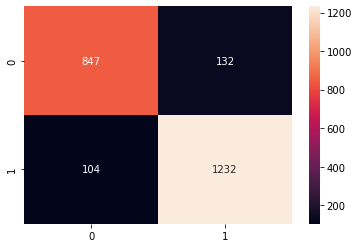

In [309]:
"""
Print the confusion matrix using heatmap to present. False Negative (FN) for safety impact defect is the worst. 
There are 132 FN case.
"""
sns.heatmap(metrics.confusion_matrix(y_test, y_pred_class),annot=True, fmt="d")

In [310]:
"""
print message of the FN for safety impact defect. 
Which can be used to dignose further to check for any error. (e.g. miscategorisation)
"""

X_test[(y_pred_class==1) & (y_test==0)]

3806     XX55/57: driver reported Car1 DDU indications ...
1674     XX 31 Car 5 indicated PACU failed and TTIS for...
31519    XX27: Car 2 indicate EHS activation opened. dr...
22049    ATS Alarm Manager showed  Air Cooling Function...
2339     Train XX19 PECU activated  for Car 1 Door A5. ...
                               ...                        
3604     XX17: EHS cover at least one open. driver chec...
5262     XX07 EB by low pressure at T0751 after departi...
3526     XX11 auxiliary equipment 7 toggling between no...
28656    XX72, Evening launching outstable train ATS al...
4581     XX35 at S8F: ATS alarms & TIP displayed Cab-to...
Name: Service_Fault_Symptoms, Length: 132, dtype: object

### Logistic Regression

In [311]:
# 1. import
from sklearn.linear_model import LogisticRegression

# 2. instantiate a logistic regression model
lg = LogisticRegression()

In [312]:
# 3. train the model using X_train_ft
lg.fit(X_train_ft, y_train)

C:\Users\Darius\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [313]:
# 4. make class predictions for X_test_ft
y_pred_class = lg.predict(X_test_ft)

In [314]:
y_pred_class

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [315]:
y_test

15633    0
28218    1
12751    0
2949     1
32046    1
        ..
34828    1
8261     1
28393    1
9740     0
7325     0
Name: Defect_Type, Length: 2315, dtype: int64

In [316]:
# 5. calculate accuracy. Scores better than NB.
metrics.accuracy_score(y_test, y_pred_class)

0.9451403887688985

# 4 Text Analysis with Feature Engineering

In [317]:
# store the words of X_train
X_train_tokens = vect.get_feature_names()
len(X_train_tokens)

5067

In [318]:
# examine the last 50 tokens
print(X_train_tokens[-50:])

['xx70', 'xx70stock', 'xx71', 'xx71air', 'xx71at', 'xx71propulsion', 'xx71was', 'xx72', 'xx73', 'xx75', 'xx77', 'xx77air', 'xx77car', 'xx78', 'xx78at', 'xx78car', 'xx78was', 'xx79', 'xxat', 'xxs', 'xxstockchange', 'xxvs', 'xxwas', 'xxxx73', 'y7', 'ya', 'yale', 'yap', 'yapinfo', 'yapwas', 'yck', 'yck_ot', 'yckot', 'yellow', 'yeo', 'yeow', 'yep', 'yet', 'yielded', 'yong', 'york', 'yt', 'yttan', 'yue', 'yup', 'zabbix', 'zeroed', 'zibbix', 'zone', 'zul']


In [319]:
# Naive Bayes counts the number of times each token appears in each class
# trailing underscore - learned during fitting
nb.feature_count_

array([[3., 0., 0., ..., 1., 0., 0.],
       [8., 1., 1., ..., 0., 4., 2.]])

In [320]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 5067)

In [321]:
# number of times each token appears across all non-safety messages
safety_token_count = nb.feature_count_[1, :]
safety_token_count

array([8., 1., 1., ..., 0., 4., 2.])

In [322]:
# number of times each token appears across all safety messages
non_safety_token_count = nb.feature_count_[0, :]
non_safety_token_count

array([3., 0., 0., ..., 1., 0., 0.])

In [323]:
# create a DataFrame of tokens with their separate safety and non-safety counts
tokens = pd.DataFrame({'token':X_train_tokens, 'safety':safety_token_count, 
                       'non_safety':non_safety_token_count}).set_index('token')
tokens.sample(5)

,safety,non_safety
token,,
cable,1.0,0.0
pres,1.0,0.0
alarmappear,1.0,0.0
7b3,0.0,1.0
710,1.0,0.0


In [324]:
# examine 5 random DataFrame rows
# random_state=1 is a seed for reproducibility
tokens.sample(5, random_state=1)

,safety,non_safety
token,,
follows,1.0,0.0
indic,1.0,0.0
intermttent,1.0,0.0
network,63.0,2.0
reclose,4.0,0.0


In [325]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([2926., 4017.])

In [326]:
tokens.dtypes

safety        float64
non_safety    float64
dtype: object

In [327]:
# +1 to safety and non-safety counts to avoid dividing by 0
tokens.iloc[:,0] = tokens.iloc[:,0].map(lambda x:x+1.0)
tokens.iloc[:,1] = tokens.iloc[:,1].map(lambda x:x+1.0)
tokens.sample(5, random_state=1)

,safety,non_safety
token,,
follows,2.0,1.0
indic,2.0,1.0
intermttent,2.0,1.0
network,64.0,3.0
reclose,5.0,1.0


In [328]:
# convert the Critical and Non-Critical counts into frequencies
tokens['safety_token_count'] = tokens["safety"] / nb.class_count_[0]
tokens['non_safety_token_count'] = tokens["non_safety"] / nb.class_count_[1]
tokens.sample(5, random_state=1)

,safety,non_safety,safety_token_count,non_safety_token_count
token,,,,
follows,2.0,1.0,0.000684,0.000249
indic,2.0,1.0,0.000684,0.000249
intermttent,2.0,1.0,0.000684,0.000249
network,64.0,3.0,0.021873,0.000747
reclose,5.0,1.0,0.001709,0.000249


In [329]:
# calculate the ratio of critical to non-critical for each token
tokens['safety_ratio'] = tokens["safety_token_count"]  / tokens["non_safety_token_count"]
tokens.sample(5, random_state=1)

,safety,non_safety,safety_token_count,non_safety_token_count,safety_ratio
token,,,,,
follows,2.0,1.0,0.000684,0.000249,2.745728
indic,2.0,1.0,0.000684,0.000249,2.745728
intermttent,2.0,1.0,0.000684,0.000249,2.745728
network,64.0,3.0,0.021873,0.000747,29.287765
reclose,5.0,1.0,0.001709,0.000249,6.864320


In [330]:
"""
# examine the DataFrame sorted by safety_ratio. These are the words used in reported symptoms that has the highest
# correlation with safety related defect.
"""

tokens.loc[:,:].sort_values('safety_ratio', ascending=False)[:5]

,safety,non_safety,safety_token_count,non_safety_token_count,safety_ratio
token,,,,,
propulsion,620.0,2.0,0.211893,0.000498,425.587833
tims,129.0,1.0,0.044087,0.000249,177.099453
pce,125.0,1.0,0.042720,0.000249,171.607997
isolated,742.0,6.0,0.253589,0.001494,169.777512
slow,121.0,1.0,0.041353,0.000249,166.116541


In [331]:
"""
There are over 5000 unique words in the symptoms in X_train (first 75% data). 
Perhaps we can reduce it using language processing technique.
"""
tokens.shape

(5067, 5)

# 5 Natural Language Processing

In [332]:
#import relevant libraries for language processing.
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

In [333]:
featuresNLP = features.copy()

In [334]:
featuresNLP.sample(5)

,Service_Fault_Symptoms,Defect_Type
3531,ATS alarm manager indicated XX75/perf07 Public...,0
9568,driver reported aircon leaking at Car1 A3door....,0
10204,driver reported Car 5 Door B1 Train Dooropened...,1
9097,TIP shows Car7 A7 door - Obstacle detected. PM...,1
27590,XX13 ATS alarm manager and TIP showed Car1 and...,1


In [335]:
#1 change the text into lower case
featuresNLP['Service_Fault_Symptoms'] = featuresNLP['Service_Fault_Symptoms'].map(lambda x:x.lower() if type(x) == str else x)

In [336]:
#2 remove punctuation using regex
featuresNLP['Service_Fault_Symptoms'] = featuresNLP['Service_Fault_Symptoms'].str.replace('[^\w\s]','', regex=True)
freq1 = pd.Series(' '.join(featuresNLP['Service_Fault_Symptoms']).split()).value_counts()
freq1.shape

(8810,)

In [337]:
#3 remove number using regex
featuresNLP['Service_Fault_Symptoms'] = featuresNLP['Service_Fault_Symptoms'].str.replace('\d','', regex=True)

In [338]:
#4 removal of stop words
stop = stopwords.words('english')

featuresNLP['Service_Fault_Symptoms'] = featuresNLP['Service_Fault_Symptoms'].map(lambda x: " ".join(x for x in x.split() if x not in stop))
freq2 = pd.Series(' '.join(featuresNLP['Service_Fault_Symptoms']).split()).value_counts()
freq2.shape

(5410,)

In [339]:
#5 removal of single alphabet words
featuresNLP['Service_Fault_Symptoms'] = featuresNLP['Service_Fault_Symptoms'].map(lambda x: " ".join(x for x in x.split() if len(x)>1))
freq3 = pd.Series(' '.join(featuresNLP['Service_Fault_Symptoms']).split()).value_counts()
freq3.shape

(5394,)

In [340]:
#6 lemmnization (better than stemming)
lm = WordNetLemmatizer()

featuresNLP['Service_Fault_Symptoms'] = featuresNLP['Service_Fault_Symptoms'][:].apply(lambda x: " ".join([lm.lemmatize(word) for word in x.split()]))
freq4 = pd.Series(' '.join(featuresNLP['Service_Fault_Symptoms']).split()).value_counts()
freq4.shape

(5246,)

<AxesSubplot:ylabel='Count'>

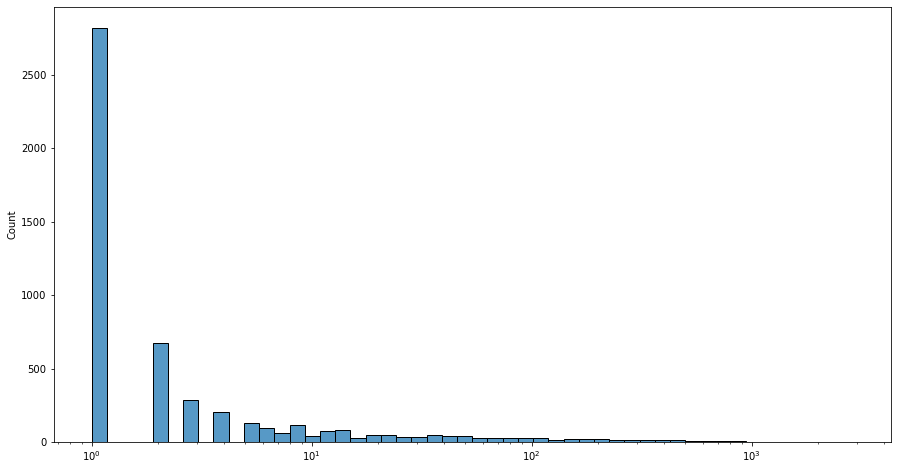

In [341]:
#Using a log x-axis scale histogram. ~90% of the words appeared less than 100 times.
plt.figure(figsize = (15,8))
sns.histplot(data=freq5, log_scale=True)

In [342]:
#calculate sum of the words appear 5 or less. ~80% (4107/5211) of the words appear less than 1 times. 
freq5.value_counts()[:1].sum()

2818

In [343]:
#7 removal words appear 1 time. removed ~54% of the words
freqwords = pd.Series(' '.join(featuresNLP['Service_Fault_Symptoms']).split()).value_counts()[-2818:]
featuresNLP['Service_Fault_Symptoms'] = featuresNLP['Service_Fault_Symptoms'].map(lambda x: " ".join(x for x in x.split() if x not in freqwords))
freq6 = pd.Series(' '.join(featuresNLP['Service_Fault_Symptoms']).split()).value_counts()
freq6.shape

(2428,)

In [344]:
featuresNLP

,Service_Fault_Symptoms,Defect_Type
8,at alarm manager tip showed car smoke fault,1
16,at alarm manager tip showed car smoke fault,1
22,snaprep xx pax reported fan working dsm informed,0
36,xx pax feedback aircon car ventilation major f...,0
57,xx driver reported car fire extinguisher panel...,0
...,...,...
35324,xx tip showed pec car unknown status console c...,0
35330,xx driver reported train proceeding slow speed...,1
35333,xx eea remote wakeup at alarm tip show car pro...,1
35334,xxperf at alarm indicated car propulsion equip...,1


In [345]:
#prepare data for ML modeling

X = featuresNLP.Service_Fault_Symptoms
y = featuresNLP.Defect_Type
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train_ft = vect.fit_transform(X_train)
X_test_ft = vect.transform(X_test)

In [346]:
#using naives. improved by ~2.3%

nb.fit(X_train_ft, y_train)
y_pred_class = nb.predict(X_test_ft)
metrics.accuracy_score(y_test, y_pred_class)

0.9239740820734341

In [347]:
#using logisticregression. accuracy of the model reduced by 0.2%

y_pred_class = lg.predict(X_test_ft)
metrics.accuracy_score(y_test, y_pred_class)

C:\Users\Darius\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9434125269978402

## Conclusion

Based on the accuracy provided, using NLP (improved by 2.3%) improves NB model but not LR model (reduced by 0.2%).